# Implementation of Model Predictive Controller (MPC)

In this notebook, I implement my first MPC in python. There seem to be a number of great pythong MPC libraries out there, including doMPC, Pytorch, and MPCpy (very new). However, APMonitor's GEKKO seemed to have extensive documentation and examples so they were a great starting point.

Good ways to add to this notebook might include setting up a tough (FOPDT or SOPDT) system to control and comparing PIDs vs an MPC

In [1]:
#try:
#    from pip import main as pipmain
#except:
#    from pip._internal import main as pipmain
#pipmain(['install','gekko'])


<class 'NoneType'>


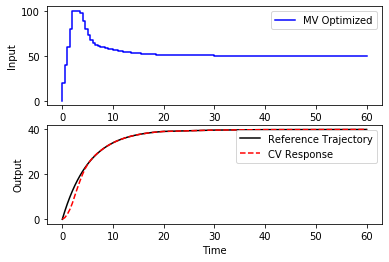

In [3]:
#Amazing!
#This is implementation of MPC by use of (free) gekko pkg
#The task now is to understand gekkos
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

m = GEKKO() #initialize gekko model
m.time = np.linspace(0,20,41) #BY DEFAULT m is set = p = number of points here, 40
m.time = np.append(m.time, [30,40,60])
m.options.CTRL_HOR = 55555555  #may be able to force a ctrl hor by fix()ing the MV to = 0 after x steps.,,see MV sxn
#m.MV_TYPE=0    #Follow up: I contacted the creator and posted to github. As of now, you can't really

# Parameters  (constants which may change over time. not changed by the solver. can be arrays) (constants are scalars)
mass = 500
b = m.Param(value=50)
K = m.Param(value=0.8)

# Manipulated variable (changed by the solver)
p = m.MV(value=0, lb=0, ub=100)
p.STATUS = 1  # allow optimizer to change
p.DCOST = 0.1 # smooth out gas pedal movement (weight for penalizing MV changes)
p.DMAX = 20   # slow down change of gas pedal (hard constraint - max MV change in a given update/step )
#m.fix(p,0,21)


# Controlled Variable
v = m.CV(value=0)
v.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
v.SP = 40     # set point
v.TR_INIT = 1 # set point trajectory
v.TAU = 5     # time constant of trajectory

# Process model
m.Equation(mass*v.dt() == -v*b + K*b*p)  #dt() is a method of v, thus its acc

m.options.IMODE = 6 # dynamic simultaneous solution of a control optimization problem; MPC can be done w modes 6, 9
m.CTRL_HOR = 5
m.solve(disp=False,debug=True,GUI=False, verify_input=True)
print(type(m.verify_input_options()))



# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',label='MV Optimized', drawstyle="steps") #CO / your manipulated variable
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
plt.plot(m.time,results['v1.tr'],'k-',label='Reference Trajectory') #filtered SP
plt.plot(m.time,v.value,'r--',label='CV Response')                  #the pv
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

In [60]:
#Can you set control horizon?
print(m.options.CTRL_HOR)
m.options.CTRL_HOR = 50
print(m.options.CTRL_HOR)
type(m.options.CTRL_HOR)
print(m.options.CTRL_TIME)
print(m.MV_TYPE)

40
50
0.5
0


Real-time control implementation:

In [113]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
from gekko import GEKKO

# Connect to Arduino
a = tclab.TCLab()

# Get Version
print(a.version)

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 5.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature (K)
T1 = np.ones(loops) * a.T1 # temperature (degC)
Tsp1 = np.ones(loops) * 30.0 # set point (degC)
# Set point changes
Tsp1[100:] = 40.0
Tsp1[200:] = 35.0

T2 = np.ones(loops) * a.T2 # temperature (degC)
Tsp2 = np.ones(loops) * 23.0 # set point (degC)

# heater values
Q1s = np.ones(loops) * 0.0
Q2s = np.ones(loops) * 0.0

#########################################################
# Initialize Model
#########################################################
# use remote=True for MacOS
m = GEKKO(name='tclab-mpc',remote=False)

# 30 second time horizon
m.time = np.linspace(0,30,31)

# Parameters
Q1_ss = m.Param(value=0)
TC1_ss = m.Param(value=23)
Kp = m.Param(value=0.4)
tau = m.Param(value=160.0)

# Manipulated variable
Q1 = m.MV(value=0)
Q1.STATUS = 1  # use to control temperature
Q1.FSTATUS = 0 # no feedback measurement
Q1.LOWER = 0.0
Q1.UPPER = 100.0
Q1.DMAX = 50.0
Q1.COST = 0.0
Q1.DCOST = 1.0e-4

# Controlled variable
TC1 = m.CV(value=TC1_ss.value)
TC1.STATUS = 1     # minimize error with setpoint range
TC1.FSTATUS = 1    # receive measurement
TC1.TR_INIT = 2    # reference trajectory
TC1.TAU = 10       # time constant for response

# Equation
m.Equation(tau * TC1.dt() + (TC1-TC1_ss) == Kp * (Q1-Q1_ss))  

# Global Options
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 1 # 1=APOPT, 3=IPOPT
##################################################################

# Create plot
plt.figure()
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        ###############################
        ### MPC CONTROLLER          ###
        ###############################
        TC1.MEAS = T1[i]
        # input setpoint with deadband +/- DT
        DT = 0.1
        TC1.SPHI = Tsp1[i] + DT
        TC1.SPLO = Tsp1[i] - DT
        # solve MPC
        m.solve(disp=False)    
        # test for successful solution
        if (m.options.APPSTATUS==1):
            # retrieve the first Q value
            Q1s[i] = Q1.NEWVAL
        else:
            # not successful, set heater to zero
            Q1s[i] = 0        

        # Write output (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(2,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'ro',MarkerSize=3,label=r'$T_1$')
        plt.plot(tm[0:i],Tsp1[0:i],'b-',MarkerSize=3,label=r'$T_1 Setpoint$')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc='best')
        ax=plt.subplot(2,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1s[0:i],'r-',LineWidth=3,label=r'$Q_1$')
        plt.plot(tm[0:i],Q2s[0:i],'b:',LineWidth=3,label=r'$Q_2$')
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    raise

ModuleNotFoundError: No module named 'tclab'

In the next cell is an MPC controlling a humble first order process (FOP). There was modest model mismatch configured between the MPC's model and the actual equation used to generate the PV. 

Other notes:
<ul>
<li>Prediction horizon was specified by supplying a list of time values</li>
<li>The control horizon defaulted to these intervals as well</li>
<li>A small weighting was applied to MV changes to encourage a steady state</li>
</ul>

<class 'NoneType'>
None


Text(0.5, 0, 'time')

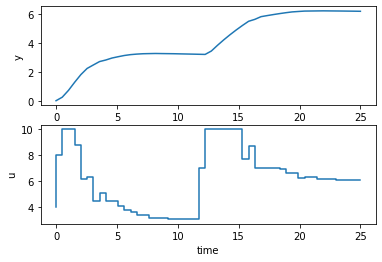

In [5]:
#######My Own########

from gekko import GEKKO
import numpy as np
import math
import matplotlib . pyplot as plt

# MPC Model
c = GEKKO ( remote=False);
c.time = np.linspace ( 0 , 20 , 21 ) #horizons are 10 with discretization of 0.5 (looks 10 units into the future)
c.time = np.append(c.time, [30,40,60])
#c.options.CSV_READ=0
#c.options.CTRL_HOR=5

#Parameters
u = c.MV( lb=-10,ub=10)       #input
K = c.Param( value=1)         #gain
tau = c.Param( value=10)      #time constant

#Variables
y = c.CV ( 1 )
#Equations
c.Equation( tau * y.dt( ) == -y + u * K ) #assume perfect fop
#Options
c.options.IMODE = 6                       #MPC
c.options.CV_TYPE = 1                     # l 1 norm
c.options.NODES = 3

y.STATUS = 1                              #Include in MPC objective
y.FSTATUS = 1                             # receive measurements
y.SPHI = 3.1
y.SPLO = 2.9


u.STATUS = 1 # enable optimization of MV
u.FSTATUS = 0 #no feedback
u.DCOST = 1 # discourage unnecessary movement
u.dmax = 4

#Time loop
cycles = 50
time = np.linspace ( 0 , cycles*.5 , cycles )
y_meas = np.empty ( cycles )
u_cont = np.empty ( cycles )
deltay = np.empty ( cycles )

print(type(u.NEWVAL))
print(u.NEWVAL)


for i in range ( cycles ) :
   
    #print(u_cont)
    #print(u.NEWVAL)
    #print(u_cont[i-1])
    #print(y_meas[i-1])

    # process
    if i ==0:
        y_meas[i] = 0
    else:
        #y_meas[i] = (1 - .5/8)*y_meas[i-1] + ( u_cont[i-1] )*.5/8*1 #FOP implemented as a difference equation WWWORKSSS!
 #1 is time step (dt) 8 is process tau 1 is process gain               (finite difference approximation)
        y_meas[i] = math.exp(-.5/8)*(y_meas[i-1])+ 1*(1-math.exp(-.5/8))*(u_cont[i-1]) #discrete time model
                                                                            #derived from analytical soln to transfer fxn

        
        #deltay = math.exp(-.5/8)*(y_meas[i]-y_meas[i-1])+ 1*(1-math.exp(-.5/8))*(u.NEWVAL-u_cont[i-1])
        #deltay[i] = .8187*(deltay[i])+ 1.1813*(u.NEWVAL-u_cont[i-1])
        #y_meas[i] = y_meas[i] + deltay[i]


    #controller
    if i == 24: ##change setpoint halfway through
        y.SPHI = 6.1
        y.SPLO = 5.9
    y.MEAS = y_meas[i]
    c.solve ( disp=False )
    u_cont[i] = u.NEWVAL


#Plot results!
plt.figure ( )
plt.subplot ( 2 , 1 , 1 )
plt.plot ( time , y_meas )
plt.ylabel ( 'y' )
plt.subplot ( 2 , 1 , 2 )
plt.plot ( time , u_cont, drawstyle="steps" )
plt.ylabel ( 'u' )
plt.xlabel ( 'time' )